# Sentiment Analysis of Amazon reviews by fine-tuning the pretrained BERT model

### Step 1: Set the GPU if available or else use CPU

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# creating a PyTorch device (device) based on whether a Compute Unified Device Architecture(CUDA)-compatible GPU is available or not. This is a common practice to automatically select the appropriate device for tensor computations.
# torch.cuda.is_available(): Checks if a CUDA-compatible GPU is available. If it returns True, it means you can use GPU acceleration; otherwise, it returns False.
# torch.device("cuda" if torch.cuda.is_available() else "cpu"): Creates a PyTorch device object based on the availability of a GPU. If a GPU is available, it sets the device to "cuda"; otherwise, it sets it to "cpu".
print("Selected device:", device)

# If a GPU is available, additional configurations can be done here
if device.type == "cuda":
    # Set the device index (you can choose the GPU index if multiple GPUs are available)
    gpu_index = torch.cuda.current_device()
    print(f"Using GPU: {torch.cuda.get_device_name(gpu_index)}")

    # Additional GPU-related configurations can be done here if needed
else:
    print("Using CPU.")

Selected device: cuda
Using GPU: Tesla T4


### Step 2: Import required packages and upload the dataset

In [7]:
import pandas as pd
import regex as re
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from google.colab import files
upload = files.upload()

Saving AmazonReviews.csv to AmazonReviews.csv


In [8]:
df = pd.read_csv('AmazonReviews.csv') # create a pandas dataframe and load the csv to it
df = df.sample(frac=1) # gives 100% the dataset
print(df.shape)
df.head(10)

(19999, 3)


,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
16928,1,Honeywell HWM-335 QuickSteam 3-Gallon Warm Moi...,Keep looking. This is VERY awkward to fill. Th...
2267,2,"Some of the funniest scenes, with an overall b...",I love this movie. It has so many individual s...
16835,1,DO NOT buy these as sealing (crush) washers,I purchased these because I was building the b...
18768,2,Slip of a memoir,"Gorgeously written, quiet memoir. Beautiful ob..."
756,2,Let's not pat ourselves on the back that this ...,I had 1984 ruined for me because I was FORCED ...
5928,2,"Pretty, dainty, worth your penny, but...",The set was agreeable in appearance I felt the...
6984,2,Uplifting and Inspirational!,I purchased the CD as a means of introduction ...
10264,2,The Very Best,This is the most wonderful tribute and concert...
1475,2,Harmonium: The Second Coming of Vanessa Carlton,"Harmonium is such an incredible record, and it..."
14107,1,Brain-Dead Beach Reading,"If Ludlum is your thing, you'll probably enjoy..."


### Step 3: Data cleansing steps

In [9]:
# Data cleansing
# Renaming the columns
new_column_names = {df.columns[0]: 'sentiment', df.columns[1]: 'text_orig_head', df.columns[2]: 'text_orig_detail'}
df.rename(columns=new_column_names, inplace=True)

# Remove the separator and merge the 2 reviews into one column to consider both under same column for model
separator = ': '
df['text_orig'] = df['text_orig_head'].str.cat(df['text_orig_detail'], sep=separator)
variables_to_drop = ['text_orig_head', 'text_orig_detail']
df.drop(variables_to_drop, axis=1, inplace=True)

df.shape

(19999, 2)

In [10]:
df.head(10)

,sentiment,text_orig
16928,1,Honeywell HWM-335 QuickSteam 3-Gallon Warm Moi...
2267,2,"Some of the funniest scenes, with an overall b..."
16835,1,DO NOT buy these as sealing (crush) washers: I...
18768,2,"Slip of a memoir: Gorgeously written, quiet me..."
756,2,Let's not pat ourselves on the back that this ...
5928,2,"Pretty, dainty, worth your penny, but...: The ..."
6984,2,Uplifting and Inspirational!: I purchased the ...
10264,2,The Very Best: This is the most wonderful trib...
1475,2,Harmonium: The Second Coming of Vanessa Carlto...
14107,1,Brain-Dead Beach Reading: If Ludlum is your th...


In [11]:
# Remove rows having NULL values
print(df.isnull().value_counts())
df=df.dropna()
print(df.isnull().value_counts())

sentiment  text_orig
False      False        19998
           True             1
dtype: int64
sentiment  text_orig
False      False        19998
dtype: int64


In [12]:
df['sentiment'].value_counts()

2    10213
1     9785
Name: sentiment, dtype: int64

In [13]:
# changing the value 1 to 0 and 2 to 1
df['sentiment'].replace({1:0,2:1}, inplace=True)
df['sentiment'].value_counts()

<ipython-input-13-f820e48552db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'].replace({1:0,2:1}, inplace=True)


1    10213
0     9785
Name: sentiment, dtype: int64

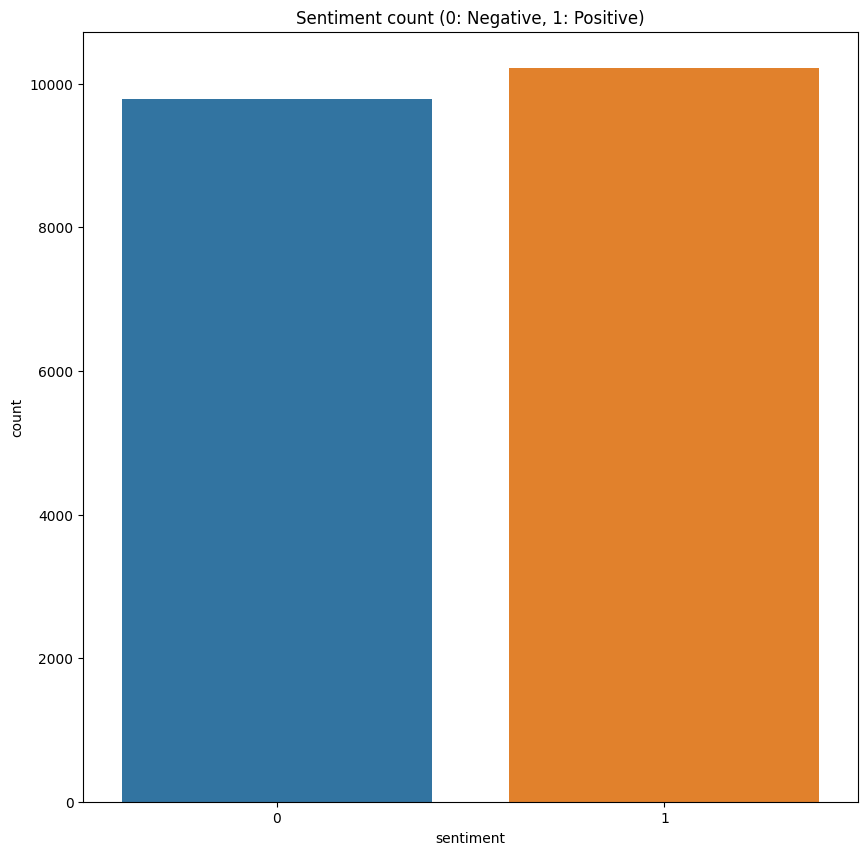

In [14]:
sns.countplot(x = 'sentiment', data = df, hue = 'sentiment', legend = False)
# create a bar chart with the categories of the 'x' variable on the x-axis and the number of observations for each category on the y-axis.
plt.title('Sentiment count (0: Negative, 1: Positive)')
plt.show()

### Step 4: Import BERT packages and set the required parameters

In [15]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
# BertConfig: This class allows you to configure the architecture of the BERT model. You can specify various parameters such as the number of layers, hidden size, attention heads, etc. You can create an instance of this class and pass it to the BERT model to customize its configuration.
# BertTokenizer: This class is responsible for tokenizing input text into subwords or words that can be used as input to the BERT model. Tokenization is a crucial step in natural language processing, and BERT requires specific tokenization to understand the contextual relationships between words.
# BertForSequenceClassification: This is a pre-trained BERT model fine-tuned for sequence classification tasks. It includes the BERT architecture with an additional classification layer on top. You can use this model for tasks like sentiment analysis, text classification, or any other sequence classification problem.

config = BertConfig.from_pretrained('bert-base-uncased', finetuning_task='binary')
# creating an instance of the BERT configuration using the BertConfig.from_pretrained method. In your example, you are loading the configuration for the 'bert-base-uncased' pre-trained BERT model and specifying the finetuning_task as 'binary'.
# BertConfig: This class allows you to configure the architecture of the BERT model. You can specify various parameters such as the number of layers, hidden size, attention heads, etc.
# from_pretrained('bert-base-uncased', finetuning_task='binary'): This method loads the pre-trained configuration for the 'bert-base-uncased' model and allows you to customize it further. In this case, you're also specifying the finetuning_task parameter as 'binary', indicating that you intend to fine-tune the model for a binary classification task.
# For 5 scale classification use config = BertConfig.from_pretrained('bert-base-uncased', num_labels=5)
# The "base" version of BERT refers to a smaller model architecture with fewer parameters compared to larger versions like "large" or "huge." The "uncased" version indicates that the model is trained on lowercased text, meaning all text is converted to lowercase before processing.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# BertTokenizer: This class is part of the Transformers library, and it is specifically designed for tokenizing text to be used with BERT models. It handles the process of breaking down input text into tokens that the BERT model can understand.
# from_pretrained('bert-base-uncased'): This method loads a pre-trained BERT tokenizer for the specified model, in this case, 'bert-base-uncased'. The 'uncased' variant indicates that the model was trained on lowercase text, which is often suitable for tasks where the case of the words may not be crucial.

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
# BertForSequenceClassification: This class is part of the Transformers library and is a specific BERT model variant fine-tuned for sequence classification tasks. It has a classification layer on top of the BERT architecture that allows it to be used for tasks like sentiment analysis, text classification, or any other sequence classification problem.
# from_pretrained('bert-base-uncased'): This method loads the pre-trained weights of the BERT model named 'bert-base-uncased'. The 'uncased' variant indicates that the model was trained on lowercase text.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 5: Define the tokenize function using BERT

In [16]:
def get_tokens(text, tokenizer, max_seq_length, add_special_tokens=True):
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens, max_length=max_seq_length, pad_to_max_length=True)
    # Tokenization: The tokenizer.encode method is used to tokenize the text. It adds special tokens (such as [CLS] and [SEP]) if add_special_tokens is set to True. The resulting tokens are then truncated or padded to fit the specified max_seq_length.
    attention_mask = [int(id > 0) for id in input_ids]
    # Attention Mask: An attention mask is created by checking whether each token ID is greater than 0. This mask is a binary list indicating which tokens are actual content (1) and which are padding tokens (0).
    assert len(input_ids) == max_seq_length
    assert len(attention_mask) == max_seq_length
    # Assertions: The function includes assertions to ensure that the length of both the input_ids and attention_mask lists is equal to the specified max_seq_length.
    return (input_ids, attention_mask)
    # Return: The function returns a tuple containing the input_ids and attention_mask.

In [17]:
# only to test the get_tokens method
text = "Here is the sample sentence I want embeddings for to test the tokenization."
input_ids, attention_mask = get_tokens(text, tokenizer, max_seq_length=30, add_special_tokens = True)
input_tokens = tokenizer.convert_ids_to_tokens(input_ids)
# The purpose of this line is to convert the token IDs back into the corresponding tokens, allowing you to inspect the tokens after tokenization. The resulting input_tokens variable will be a list of strings, where each string represents a word or subword token in the original text.
print(input_tokens)
print(input_ids)
print(attention_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['[CLS]', 'here', 'is', 'the', 'sample', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', 'to', 'test', 'the', 'token', '##ization', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 2182, 2003, 1996, 7099, 6251, 1045, 2215, 7861, 8270, 4667, 2015, 2005, 2000, 3231, 1996, 19204, 3989, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Step 6: Create the Train and Test datasets from the source dataset and Tokenize

In [18]:
from sklearn.model_selection import train_test_split
# train_test_split function from scikit-learn is commonly used to split a dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    df['text_orig'],  # Features (independent variable)
    df['sentiment'],  # Labels or target variable (dependent variable)
    test_size=0.2,       # Percentage of data to be used for testing (here, 20%)
    random_state=42,     # Seed for reproducibility
    stratify=df['sentiment']  # Ensures that the distribution of 'sentiment' is similar in both sets
)
X_train_tokens = X_train.apply(get_tokens, args=(tokenizer, 50)) # applying get_tokens function to the elements of X_train using the apply method. Passing the function parameters as arguments.
X_test_tokens = X_test.apply(get_tokens, args=(tokenizer, 50)) # applying get_tokens function to the elements of X_test using the apply method. Passing the function parameters as arguments.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Step 7: Create the required Tensors from the Train and Test datasets

In [19]:
import torch #  importing the PyTorch library, a popular deep learning framework in Python. PyTorch is widely used for building and training neural network models.
from torch.utils.data import TensorDataset # importing the TensorDataset class from the PyTorch torch.utils.data module. TensorDataset is a PyTorch class that allows you to create a dataset from tensors. This can be useful when working with data in a PyTorch-friendly format.
input_ids_train = torch.tensor( [features[0] for features in X_train_tokens.values], dtype=torch.long)
# creating a PyTorch tensor named input_ids_train based on the values from X_train_tokens since X_train_tokens contains sequences of tokenized text data, and you're extracting the first feature from each tokenized sequence to create a tensor of input IDs.
input_mask_train = torch.tensor( [features[1] for features in X_train_tokens.values], dtype=torch.long)
# creating another PyTorch tensor named input_mask_train based on the values from X_train_tokens since in the tokenized sequences, the second feature (index 1) in each sequence is used to create a tensor representing a mask.
label_ids_train = torch.tensor(Y_train.values, dtype=torch.long)
# creating a PyTorch tensor named label_ids_train based on the values from Y_train

print (input_ids_train.shape)
print (input_mask_train.shape)
print (label_ids_train.shape)

torch.Size([15998, 50])
torch.Size([15998, 50])
torch.Size([15998])


In [20]:
input_ids_train[1]

tensor([  101, 10047,  2200,  6314,  1024,  1057,  5638,  2005,  2035,  1996,
         1044, 18863,  2017,  3659,  2006,  2023,  4935,  5308,  2009,  2001,
         2025,  4276,  1996,  2382,  1045,  3825,  2005,  2009,  1012,  1996,
         7341,  2474,  2290,  2428,  2919,  1012,  2074,  2066,  1996,  2060,
         2111,  2056,  2077,  1045,  2131,  2382,  1011,  3963,  1042,   102])

In [21]:
input_ids_test = torch.tensor( [features[0] for features in X_test_tokens.values], dtype=torch.long)
# creating a PyTorch tensor named input_ids_test based on the values from X_test_tokens. First feature (index 0) in each tokenized sequence is used to create a tensor representing input IDs for testing data.
input_mask_test = torch.tensor( [features[1] for features in X_test_tokens.values], dtype=torch.long)
# creating a PyTorch tensor named input_mask_test by extracting the second element from each row of your DataFrame X_test_tokens.values.
label_ids_test = torch.tensor(Y_test.values, dtype=torch.long)
# creating another PyTorch tensor named label_ids_test from the values of a DataFrame Y_test.

print (input_ids_test.shape)
print (input_mask_test.shape)
print (label_ids_test.shape)

torch.Size([4000, 50])
torch.Size([4000, 50])
torch.Size([4000])


In [22]:
input_ids_test[1]

tensor([  101,  3791,  2000, 12919,  2993,  1024,  2023,  2338,  2001,  2025,
         2200,  2092,  2517,  1012,  1045,  2245,  2008,  1996,  6939,  2078,
         2001,  2126,  2205,  3733,  1998,  2008,  1996,  3454,  2333,  2247,
         2012,  1037, 16668,  4030,  6393,  1012,  2036,  1010,  1996,  7850,
         2013,  8506,  2134,  1005,  1056,  4025,  2000,  2113,  2054,   102])

### Step 8: Create PyTorch Tensor Datasets from the tensors

In [23]:
train_dataset = TensorDataset(input_ids_train,input_mask_train,label_ids_train)
# creating a PyTorch TensorDataset named train_dataset by combining three tensors: input_ids_train, input_mask_train, and label_ids_train. This is a common practice when preparing data for training deep learning models.
# input_ids_train: Tensor containing input IDs (likely representing tokenized input sequences).
# input_mask_train: Tensor containing input masks (if using transformers, this might represent padding masks to distinguish real tokens from padding tokens).
# label_ids_train: Tensor containing label IDs (target values for your training data).
# TensorDataset is a PyTorch class that allows you to create a dataset from a sequence of tensors, where each tensor represents a different aspect of your data (input features, masks, labels, etc.). This is useful when working with PyTorch's DataLoader for batching and iterating through your dataset during training.

test_dataset = TensorDataset(input_ids_test,input_mask_test,label_ids_test)
# creating a PyTorch TensorDataset named test_dataset by combining three tensors: input_ids_test, input_mask_test, and label_ids_test. This is a common practice when preparing a dataset for testing or evaluation in a deep learning model.
# input_ids_test: Tensor containing input IDs for your test data.
# input_mask_test: Tensor containing input masks for your test data.
# label_ids_test: Tensor containing label IDs for your test data.

### Step 9: Setting up Random sampler, Data loader and other training parameters

In [24]:
from torch.utils.data import DataLoader, RandomSampler
# importing modules (DataLoader and RandomSampler) from the PyTorch torch.utils.data package. These modules are commonly used in PyTorch for creating data loaders that can handle batches of data during training or evaluation.

train_batch_size = 100
num_train_epochs = 10

train_sampler = RandomSampler(train_dataset)
# The RandomSampler is commonly used during training to shuffle the data at each epoch, which helps the model generalize better.

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)
# creating a DataLoader named train_dataloader for your training dataset (train_dataset) using the provided RandomSampler (train_sampler) and a specified batch size (train_batch_size).

t_total = len(train_dataloader) // num_train_epochs
# calculating the total number of training steps (t_total) based on the length of your training data loader (train_dataloader) and the number of training epochs (num_train_epochs).

print ("Num examples = ", len(train_dataset))
print ("Num Epochs = ", num_train_epochs)
print ("Total train batch size = ", train_batch_size)
print ("Total optimization steps = ", t_total)

Num examples =  15998
Num Epochs =  10
Total train batch size =  100
Total optimization steps =  16


### Step 10: Setting up AdamW optimizer and Scheduler

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup
# importing components from the Transformers library, for fine-tuning a pre-trained model using the AdamW optimizer and a learning rate scheduler.

learning_rate = 1e-4 # This line sets the initial learning rate for the optimizer. In this case, it's set to 1e-4 (0.0001).
adam_epsilon = 1e-8 # This line sets the epsilon value for numerical stability in the AdamW optimizer. Epsilon is a small value added to the denominator to prevent division by zero. Here, it's set to 1e-8 (0.00000001).
warmup_steps = 0 # This line sets the number of warmup steps for the learning rate scheduler. Warmup steps gradually increase the learning rate from 0 to the initial learning rate over a certain number of steps.

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
# setting up the AdamW optimizer for your model with the specified learning rate (learning_rate) and epsilon value (adam_epsilon). Number of warm-up steps (warmup_steps) is set to 0, meaning there won't be any warm-up phase.

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
# setting up a linear learning rate scheduler with warm-up using the get_linear_schedule_with_warmup function. This scheduler is intended to be used in conjunction with the AdamW optimizer for fine-tuning your model.

# the AdamW optimizer and scheduler are crucial components of BERT training to ensure efficient optimization, prevent overfitting, and stabilize the training process. They help to address challenges such as vanishing or exploding gradients, slow convergence, and overfitting, which are common in deep learning tasks like training BERT models on large text corpora.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Step 11: Model Training of pretrained BERT model

In [26]:
from tqdm import trange, notebook
# These functions are commonly used for creating progress bars in loops, making it easier to visualize the progress of lengthy computations, especially in Jupyter notebooks.

train_iterator = trange(num_train_epochs, desc="Epoch")
# creating a tqdm progress bar using trange to iterate over the training epochs. The trange function is particularly useful for creating a progress bar in loops, providing a visual indication of the progress.

#Put model in 'train' mode
model.train()
#This is an important step when training neural networks as it activates certain behaviors in the model that are specific to training. Some common effects of calling model.train() include:
# Activation of Dropout Layers: During training, dropout layers are activated, which randomly "drop out" some neurons during forward and backward passes. This helps prevent overfitting.
# Batch Normalization Updates: Batch normalization layers keep track of the running mean and variance during training. When model.train() is called, batch normalization layers use batch statistics for normalization. During evaluation or inference, you typically use the running statistics.
# Autograd Tracking: PyTorch keeps track of operations for automatic differentiation during training. Calling model.train() ensures that autograd is enabled.

for epoch in train_iterator: # The nested for loop iterates over each epoch (for epoch in train_iterator) and each batch (for step, batch in enumerate(epoch_iterator)).
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration") # the notebook.tqdm function is specifically designed for use within Jupyter notebooks to display a progress bar with notebook integration. If you're not using a Jupyter notebook, you can simply use tqdm instead of notebook.tqdm.
    for step, batch in enumerate(epoch_iterator):

        # Reset all gradients at start of every iteration. Clears the gradients of all optimized parameters before the backward pass.
        model.zero_grad()

        # Put the model and the input observations to GPU
        model.to(device) # Moves the entire model to the specified device ('cuda' if available, otherwise 'cpu').
        batch = tuple(t.to(device) for t in batch) # Moves each tensor in the batch to the same device.

        # Prepares the inputs in a dictionary format expected by the model. It includes input IDs, attention masks, and labels.
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        # Forward Pass through the model. Input -> Model -> Output
        outputs = model(**inputs) # Performs a forward pass through the model using the input batch (inputs).

        # Determine the deviation (loss)
        loss = outputs[0] # Extracts the loss from the model's output.
        print("\r%f" % loss, end='') # Prints the current loss value during training. The use of \r ensures that the loss is overwritten in the same line, providing a dynamic update.

        # Computes gradients of the loss with respect to model parameters using backpropagation.
        loss.backward()

        # Clips gradients to prevent exploding gradients by limiting gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the parameters and learning rate
        optimizer.step() # Updates model parameters using the optimizer (e.g., Adam).
        scheduler.step() # Updates the learning rate scheduler. Learning rate scheduling can be crucial for optimizing training.

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.312504

Epoch:  10%|█         | 1/10 [01:52<16:53, 112.57s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.367933

Epoch:  20%|██        | 2/10 [03:50<15:23, 115.48s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.314392

Epoch:  30%|███       | 3/10 [05:47<13:35, 116.52s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.336169

Epoch:  40%|████      | 4/10 [07:45<11:42, 117.02s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.283057

Epoch:  50%|█████     | 5/10 [09:43<09:46, 117.28s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.269038

Epoch:  60%|██████    | 6/10 [11:41<07:49, 117.41s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.345504

Epoch:  70%|███████   | 7/10 [13:38<05:52, 117.52s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.360660

Epoch:  80%|████████  | 8/10 [15:36<03:55, 117.57s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.358055

Epoch:  90%|█████████ | 9/10 [17:34<01:57, 117.65s/it]

Iteration:   0%|          | 0/160 [00:00<?, ?it/s]

0.360965

Epoch: 100%|██████████| 10/10 [19:32<00:00, 117.22s/it]


### Step 12: Save the files related to the model (configuration and weights used)

In [27]:
model.save_pretrained('outputs')

# This method is part of the Hugging Face Transformers library. It saves both the model configuration and the model weights to the specified directory ('outputs' in this case).
# After running this code, the 'outputs' directory will contain files related to the saved model, including a configuration file (config.json) describing the model architecture and a file containing the model weights (pytorch_model.bin).

### Step 13: Model Evaluation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import SequentialSampler # SequentialSampler: This is a PyTorch data sampler that provides indices in a sequential order, i.e., it returns indices in the order [0, 1, 2, ..., N-1], where N is the total number of samples in your dataset. It is often used during validation or testing when you want to process the data in the same order every time.
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, roc_auc_score # This function is part of scikit-learn (sklearn). It is used to compute the accuracy, confusion matrix, roc curve of a classification model by comparing the true labels (ground truth) with the predicted labels.

test_batch_size = 64 # Specifies the batch size for the test DataLoader. It determines the number of samples in each batch during evaluation.
test_sampler = SequentialSampler(test_dataset) # Creates a sequential sampler for the test dataset.
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size) # Creates a DataLoader for the test dataset. The DataLoader is responsible for iterating over batches of data during testing, using the specified SequentialSampler for sampling and the specified test_batch_size for batch size.

# Initialize the prediction and actual labels
preds = None # used to accumulate the model predictions
out_label_ids = None # used to accumulate the true labels (out_label_ids) during the evaluation

# Put model in "eval" mode
model.eval()
for batch in notebook.tqdm(test_dataloader, desc="Evaluating"): # This loop iterates through the batches in the test_dataloader. notebook.tqdm is used to display a progress bar during the evaluation.
  # Put the model and the input observations to GPU
  model.to(device) # moves the entire model to the specified device (device), which is usually either 'cuda' (GPU) or 'cpu' (CPU).
  batch = tuple(t.to(device) for t in batch) # moves each tensor in the batch to the same device. It ensures that both the model and the input data are on the same device, enabling efficient computation on either the GPU or CPU.

  # Do not track any gradients since in 'eval' mode
  with torch.no_grad(): # good practice to disable gradient calculation and save memory when you're not training the model.
    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2]} # creates a dictionary inputs with the keys 'input_ids', 'attention_mask', and 'labels', where each key corresponds to a tensor in the batch. Input data consists of tokenized input IDs, attention masks, and labels.

    # Forward pass through the model
    outputs = model(**inputs) # perform the forward pass through your model during evaluation to compute predictions on input data

    # We get loss since we provided the labels
    tmp_eval_loss, logits = outputs[:2] # unpacking the outputs from the model into tmp_eval_loss and logits using slicing
    # outputs[:2]: This syntax slices the outputs tensor, extracting the first two elements.
    # tmp_eval_loss: This variable is assigned the value of the first element of outputs. It's common for the first element of the model's output to represent the loss during training or evaluation.
    # logits: This variable is assigned the value of the second element of outputs. In many classification tasks, the second element often represents the model's raw predictions (logits) before applying activation functions like softmax.

    # There maybe more than one batch of items in the test dataset
    if preds is None: # This checks whether preds is None, indicating that this is the first iteration through the loop (for the first batch).
      preds = logits.detach().cpu().numpy() # If it's the first iteration, preds is assigned the numpy array obtained by detaching the logits from the computational graph, moving them to the CPU, and converting them to a NumPy array.
      out_label_ids = inputs['labels'].detach().cpu().numpy() # Similarly, out_label_ids is assigned the numpy array obtained by detaching the true labels (inputs['labels']), moving them to the CPU, and converting them to a NumPy array.
    else: # If it's not the first iteration (i.e., for subsequent batches), the code appends the new logits and true labels to the existing preds and out_label_ids arrays.
      preds = np.append(preds, logits.detach().cpu().numpy(), axis=0) # Appends the new logits to the existing preds array along the specified axis (axis=0 means along rows).
      out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0) # Appends the new true labels to the existing out_label_ids array along the specified axis.


# Get final loss, predictions and accuracy
preds = np.argmax(preds, axis=1) #  uses np.argmax to select the index with the highest probability along the specified axis (axis=1). This is commonly done to convert the model's raw logits into class predictions. It assumes a classification task where you want to predict the class with the highest probability.
acc_score = accuracy_score(preds, out_label_ids) # calculates the accuracy score using the accuracy_score function from scikit-learn. It compares the predicted labels (preds) with the true labels (out_label_ids) and computes the accuracy.
print ('Accuracy Score on Test data ', acc_score) # Finally, this line prints the calculated accuracy score on the test data.

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy Score on Test data  0.87875


In [29]:
cm = confusion_matrix(preds, out_label_ids)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1652  180]
 [ 305 1863]]


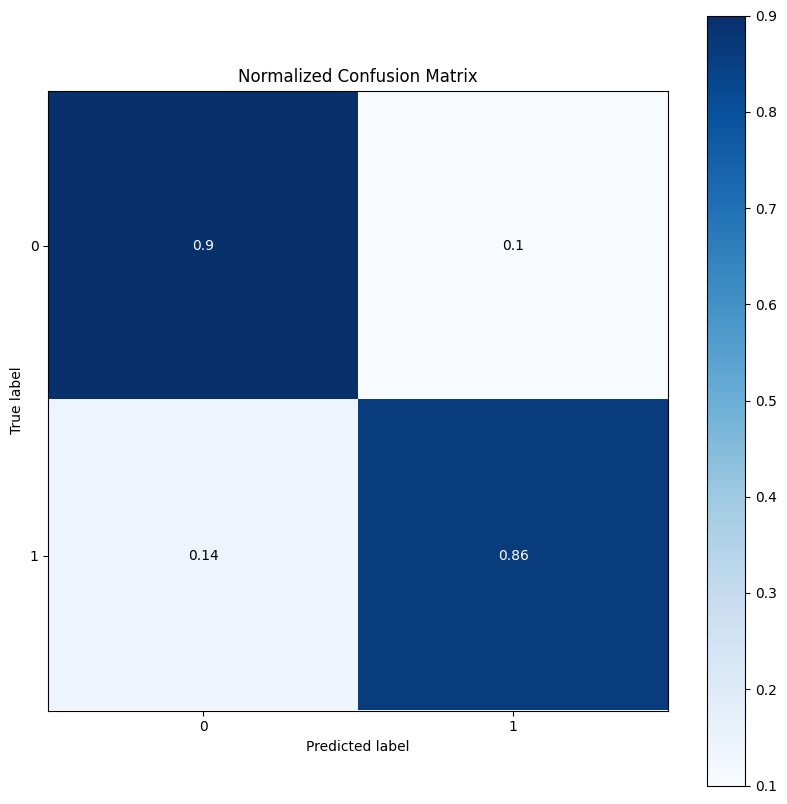

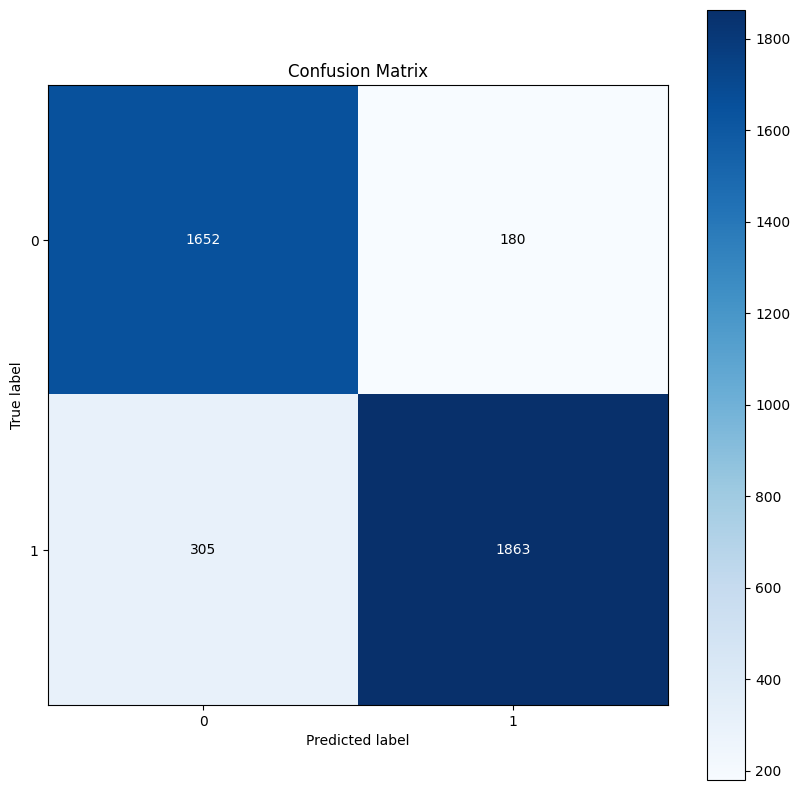

0.87875
0.878021740549569
0.8805320340321308
0.8784116728805196


In [32]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn import metrics
plt.rcParams['figure.figsize'] = [10, 10]

skplt.metrics.plot_confusion_matrix(preds, out_label_ids, normalize=True)
plt.show()
skplt.metrics.plot_confusion_matrix(preds, out_label_ids, normalize=False)
plt.show()

print('Accuracy Score: ', accuracy_score(preds, out_label_ids))
print('Precision Score: ', precision_score(preds, out_label_ids, average='macro'))
print('Recall Score: ', recall_score(preds, out_label_ids,average='macro'))
print('F1 Score: ', f1_score(preds, out_label_ids,average='macro'))

plt.show()

# Visual representation to support business decisions

### Step 14: Segregate the positive and negative sentiment dataframes

In [33]:
#create negative sentiment dataframe
negative = df[(df['sentiment'] == 0)]

#create positive sentiment dataframe
positive = df[(df['sentiment'] == 1)]

print(positive['sentiment'].value_counts())
print(negative['sentiment'].value_counts())

1    10213
Name: sentiment, dtype: int64
0    9785
Name: sentiment, dtype: int64


### Step 15: Create functions to tokenize, remove stopwords and use pipeline

In [34]:
#define the tokenize function
def tokenize_wc(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)

In [35]:
#define the remove stop words function
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [36]:
#define the pipeline
pipeline = [str.lower, tokenize_wc, remove_stop]
#define a function (prepare) which executes the pipeline
def prepare(text, pipeline):
  tokens = text
  for fun in pipeline:
    tokens = fun(tokens)
  return tokens

### Step 16: Create positive and negative tokens in the corresponding DataFrames

In [37]:
#Create tokens for the negative and positive dataframes
negative['tokens'] = negative['text_orig'].apply(prepare, pipeline=pipeline)
positive['tokens'] = positive['text_orig'].apply(prepare, pipeline=pipeline)

<ipython-input-37-ee8a86a37533>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative['tokens'] = negative['text_orig'].apply(prepare, pipeline=pipeline)
<ipython-input-37-ee8a86a37533>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['tokens'] = positive['text_orig'].apply(prepare, pipeline=pipeline)


## ------------------ For negative review Tokens ------------------

### Step 17: Count the negative token frequency using counter

In [38]:
# Negative - Check the word frequency and make a dataframe using Counter
from collections import Counter
counter = Counter() # create a counter object
negative['tokens'].map(counter.update) # checks the tokens in the variable and update the counter for each token
freq_df_negative = pd.DataFrame.from_dict(counter, orient='index',columns=['freq']) # convert the counter to a dataframe
freq_df_negative = freq_df_negative.query('freq >= 1') # filter the tokens having frequency >= 1
freq_df_negative.index.name = 'token' # set the index name as token for the dataframe
freq_df_negative = freq_df_negative.sort_values('freq', ascending=False) # sort the dataframe based on the frequency in the descending order
freq_df_negative.head(20) # fetch the 20 top most frequent tokens from the dataframe

,freq
token,
book,5725
one,3966
movie,3350
like,3172
would,2721
good,2538
get,2159
time,2106
read,1986


### Step 18: Calculate the TF-IDF values for each negative token

In [39]:
# Calculate Inverse Document Frequency(IDF)
import numpy as np

def compute_idf(df, column='tokens', preprocess = None, min_df = 1):
# preprocess = None
# If you don't want to perform any preprocessing, you can omit the preprocess parameter, and the function
# will default to using the original tokens in the DataFrame.

# min_df = 1
# Adjusting the min_df parameter allows you to control the inclusion of terms based on their frequency across the entire document collection.
# For example, if min_df is set to 1, the function will include terms that appear in at least one document.
# If you set min_df to 2, it will include terms that appear in at least two documents, and so on.
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        # If preprocess is None, it assumes that doc is already a list of tokens.
        # If preprocess is a function, it applies that function to doc to obtain the list of tokens.
        counter.update(set(tokens))
        # set(tokens): It converts the list of tokens into a set. The use of set is to ensure that
        # each unique token is only counted once, even if it appears multiple times in the document.

# count tokens
    counter = Counter() # counter is initialized using the Counter() class.
    df[column].map(update) # The map function is used to apply the update function to each document in the specified column (df[column]).
# create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
# The function creates a DataFrame (idf_df) from the Counter, where the index is the token, and the column 'df' represents the document frequency.
    idf_df = idf_df.query('df >= @min_df') # It filters out terms that appear less than min_df times.
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1 # IDF is calculated using the formula
    idf_df.index.name = 'token'
    return idf_df # The resulting DataFrame includes the token, document frequency (df), and IDF values.

In [40]:
neg_idf_df = compute_idf(negative)
print(neg_idf_df)

            df       idf
token                   
hard       471  3.133748
3-gallon     1  9.288606
got        727  2.699679
lower       39  5.625044
able       219  3.899534
...        ...       ...
planterit    1  9.288606
smartcat     1  9.288606
repotted     1  9.288606
dc100        1  9.288606
dvd-rw       1  9.288606

[35427 rows x 2 columns]


In [41]:
freq_df_negative['tfidf'] = freq_df_negative['freq'] * neg_idf_df['idf']
freq_df_negative.head(20)

,freq,tfidf
token,,
book,5725,8146.870349
one,3966,5200.710560
movie,3350,6451.968042
like,3172,4759.250789
would,2721,4341.573538
good,2538,4289.744225
get,2159,3901.421334
time,2106,3824.717415
read,1986,4013.865778


### Step 19: Create the WordCloud using tokens of negative sentiments

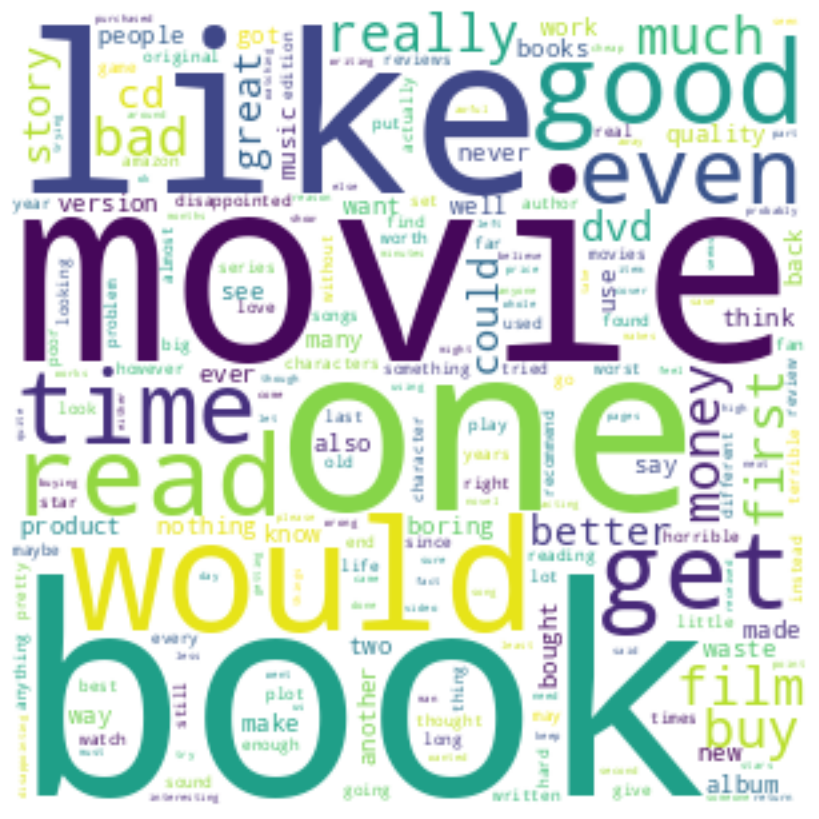

In [42]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud(background_color='white', width = 300, height=300,margin=2) # create a wordcloud object and passing parameters
wc.fit_words(freq_df_negative['tfidf'].to_dict())
# The fit_words method is used to generate a word cloud from a dictionary where keys are words,
# and values are their corresponding frequencies or importance scores.
plt.figure(figsize = (8, 8), facecolor = None) # This will create a figure with a size of 8x8 inches and a transparent background
plt.imshow(wc, interpolation='bilinear') # good practice to set the interpolation method and axis properties for a clearer display
plt.axis("off")
plt.tight_layout(pad = 0) # command is used to adjust the spacing between subplots to make sure that the elements do not overlap.
plt.show()

## ------------------ For positive review Tokens ------------------

### Step 20: Count the positive token frequency using counter

In [43]:
positive['tokens'].map(counter.update) # checks the tokens in the variable and update the counter for each token
freq_df_positive = pd.DataFrame.from_dict(counter, orient='index',columns=['freq']) # convert the counter to a dataframe
freq_df_positive = freq_df_positive.query('freq >= 1') # filter the tokens having frequency >= 1
freq_df_positive.index.name = 'token' # set the index name as token for the dataframe
freq_df_positive = freq_df_positive.sort_values('freq', ascending=False) # sort the dataframe based on the frequency in the descending order
freq_df_positive.head(20) # fetch the 20 top most frequent tokens from the dataframe

,freq
token,
book,11811
one,7999
movie,6140
great,5990
good,5983
like,5925
read,4791
would,4442
time,3986


### Step 21: Calculate the TF-IDF values for each positive token

In [44]:
pos_idf_df = compute_idf(positive)
print(pos_idf_df)

                 df       idf
token                        
driving          45  5.524754
humor           138  4.404163
fluid             6  7.539657
greatest        208  3.993879
say             589  2.952991
...             ...       ...
jensen            1  9.331417
plausibility      1  9.331417
incarceration     1  9.331417
violets           1  9.331417
rehabilitation    1  9.331417

[36528 rows x 2 columns]


In [45]:
freq_df_positive['tfidf'] = freq_df_positive['freq'] * pos_idf_df['idf']
freq_df_positive.head(20)

,freq,tfidf
token,,
book,11811,16198.103464
one,7999,10601.734768
movie,6140,12806.576408
great,5990,7364.321435
good,5983,8904.814090
like,5925,9952.940158
read,4791,8706.023356
would,4442,9087.932882
time,3986,7834.896987


### Step 22: Create the WordCloud using tokens of positive sentiments

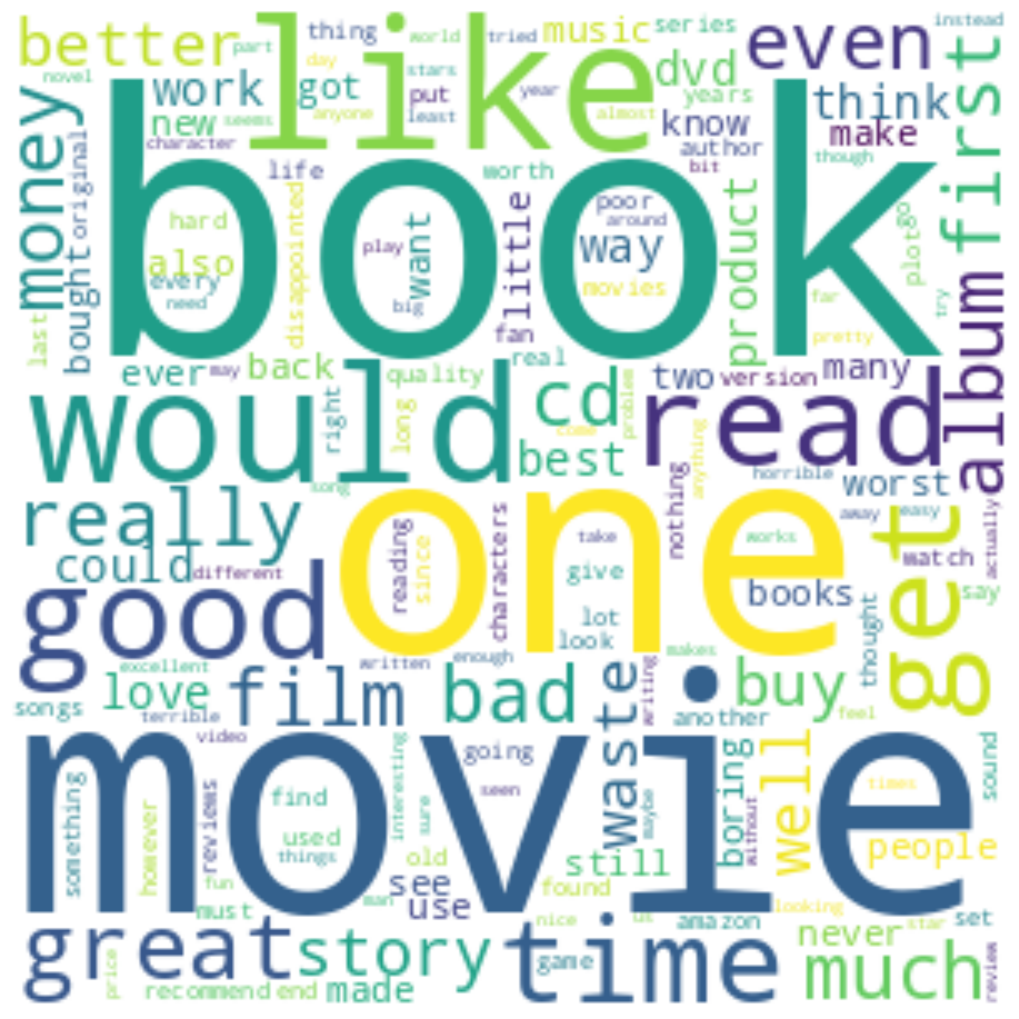

In [46]:
wc.fit_words(freq_df_positive['tfidf'].to_dict())
# The fit_words method is used to generate a word cloud from a dictionary where keys are words,
# and values are their corresponding frequencies or importance scores.
plt.figure(figsize = (10, 10), facecolor = None) # This will create a figure with a size of 8x8 inches and a transparent background
plt.imshow(wc, interpolation='bilinear') # good practice to set the interpolation method and axis properties for a clearer display
plt.axis("off")
plt.tight_layout(pad = 0) # command is used to adjust the spacing between subplots to make sure that the elements do not overlap.
plt.show()